In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravhydro import densities, density_i, W
import plotly.graph_objects as go

# Data

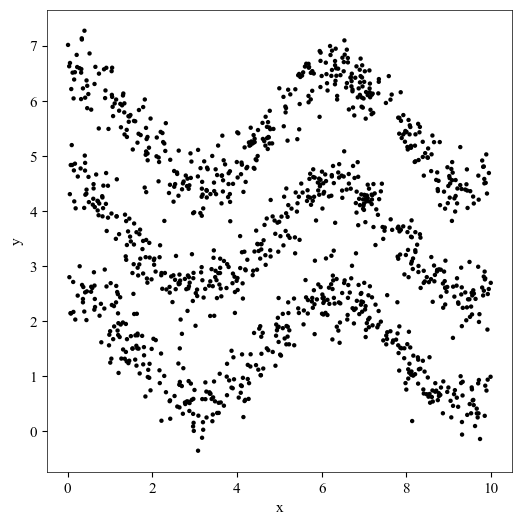

In [2]:
# Positions
dy = 1.0
lim = 1.0
lim0 = 1.0
y = np.array([])
npts = 400
nsteps = 3
total_N = npts * nsteps
for i in range(nsteps):
    new_y = np.random.normal(lim + dy/2, dy/3, npts)# np.random.uniform(lim, lim + dr, 200)
    lim += dy*2
    y = np.append(y, new_y)
x_ls = np.random.uniform(0, 10, total_N)
y_ls = y + np.cos(x_ls)
pos = np.array([x_ls, y_ls]).T

# Masses
masses = np.ones(pos.shape[0])*10


# Plot
plt.figure(figsize=(6, 6))
plt.scatter(pos[:, 0], pos[:, 1], s=masses)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Density
$  \rho_i = \sum_j m_j W(r_i - r_j, h_i)$

*Essentially, we can estimate the density at a particle's location by taking a weighted sum of the rest of the mass. The sum is weighed by the kernel function, $W$.*

Calculating density is as simple as:

In [3]:
rhos = densities(pos, masses, h=1.0) 

In [27]:
pos.shape

(1200, 2)

In [42]:
xgrid = np.linspace(np.min(pos[:,0]), np.max(pos[:,0]), 40)
ygrid = np.linspace(np.min(pos[:,1]), np.max(pos[:,1]), 40)
initial_h = 0.2
h_values = np.linspace(initial_h, 2, 10)


# Visualizing the effect of the choice of `h`

In [43]:
# Pre-calculate all density grids
all_density_grids = {}
for h in h_values:
    density_grid = np.zeros((len(xgrid), len(ygrid)))
    for i, x in enumerate(xgrid):
        for j, y in enumerate(ygrid):
            density_grid[i, j] = density_i(np.array([x, y]), pos, masses, h=h)
    all_density_grids[h] = density_grid

# Get axis limits from particle positions
xmin, xmax = pos[:, 0].min(), pos[:, 0].max()
ymin, ymax = pos[:, 1].min(), pos[:, 1].max()

# Create frames that ONLY update the heatmap (trace index 0)
frames = []
for h in h_values:
    density_grid = all_density_grids[h]
    frame = go.Frame(
        data=[
            go.Heatmap(
                z=density_grid.T,
                x=xgrid,
                y=ygrid,
                colorscale="Magma",
                colorbar=dict(
                    title=dict(text="density →", side="right", font=dict(size=18)),
                    tickvals=[],
                    len=0.5,
                    y=0.5,
                    yanchor="middle",
                ),
            ),
        ],
        name=f"h={h:.2f}",
        traces=[0],
    )
    frames.append(frame)

# Create the initial plot with scatter points
initial_density_grid = all_density_grids[initial_h]

# Create the figure with both heatmap and scatter
fig = go.Figure(
    data=[
        go.Heatmap(
            z=initial_density_grid.T,
            x=xgrid,
            y=ygrid,
            colorscale="Magma",
            colorbar=dict(
                title=dict(text="density →", side="right", font=dict(size=18)),
                tickvals=[],
                len=0.5,
                y=0.5,
                yanchor="middle",
            ),
        ),
        go.Scatter(
            x=pos[:, 0],
            y=pos[:, 1],
            mode='markers',
            marker=dict(color='white', size=3, opacity=0.6),
            name='Particles',
            visible=True,
        )
    ],
    layout=go.Layout(
        xaxis=dict(
            title=dict(text="x", font=dict(size=18)),
            constrain="domain",
            range=[xmin, xmax],
            showticklabels=False,
        ),
        yaxis=dict(
            title=dict(text="y", font=dict(size=18)),
            scaleanchor="x",
            scaleratio=1,
            constrain="domain",
            range=[ymin, ymax],
            showticklabels=False,
        ),
        width=700,
        height=700,
        margin=dict(t=80),
        sliders=[
            dict(
                active=0,
                currentvalue={"prefix": "h: ", "font": {"size": 18}},
                pad={"t": 50},
                font=dict(size=14),
                steps=[
                    dict(
                        method="animate",
                        args=[
                            [f"h={h:.2f}"],
                            dict(
                                frame=dict(duration=0, redraw=True),
                                mode="immediate",
                                transition=dict(duration=0)
                            ),
                        ],
                        label=f"{h:.2f}",
                    )
                    for h in h_values
                ],
            )
        ],
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                direction="left",
                x=0.0,
                y=1.12,
                xanchor="left",
                yanchor="top",
                buttons=[
                    dict(
                        label="▶",
                        method="animate",
                        args=[None, dict(
                            frame=dict(duration=500, redraw=True),
                            fromcurrent=True,
                            transition=dict(duration=0)
                        )],
                    ),
                    dict(
                        label="⏸",
                        method="animate",
                        args=[[None], dict(
                            frame=dict(duration=0, redraw=True),
                            mode="immediate",
                            transition=dict(duration=0)
                        )],
                    ),
                ],
            ),
            dict(
                type="buttons",
                showactive=True,
                direction="left",
                x=1.0,
                y=1.12,
                xanchor="right",
                yanchor="top",
                buttons=[
                    dict(
                        label="Show Particles",
                        method="restyle",
                        args=[{"visible": True}, [1]],
                    ),
                    dict(
                        label="Hide Particles",
                        method="restyle",
                        args=[{"visible": False}, [1]],
                    ),
                ],
            ),
        ],
    ),
    frames=frames,
)

fig.show()

## Export to GitHub Pages

In [44]:
# Export the figure to HTML for GitHub Pages
import os

# Path to docs/widgets folder (relative to repo root)
output_path = "../../docs/widgets/density_estimation.html"

# Write the figure as a standalone HTML file
fig.write_html(
    output_path,
    include_plotlyjs=True,  # Include plotly.js in the file for standalone use
    full_html=True,
    config={
        'displayModeBar': True,
        'displaylogo': False,
        'modeBarButtonsToRemove': ['select2d', 'lasso2d']
    }
)

print(f"Widget exported to: {os.path.abspath(output_path)}")

Widget exported to: /Users/gabrielpfaffman/gravHydro/docs/widgets/density_estimation.html


# Further Convergence Testing

In [5]:
# most distant particle separation:
max_sep = np.max(np.linalg.norm(pos[:, np.newaxis, :] - pos[np.newaxis, :, :], axis=2))
print("max particle separation:", max_sep)
theoretical_max_density = np.sum(masses * W(np.array([0.0]), h=1))
print("theoretical max density (h=1):", theoretical_max_density)

max particle separation: 12.075272443371222
theoretical max density (h=1): 3819.7186342054883


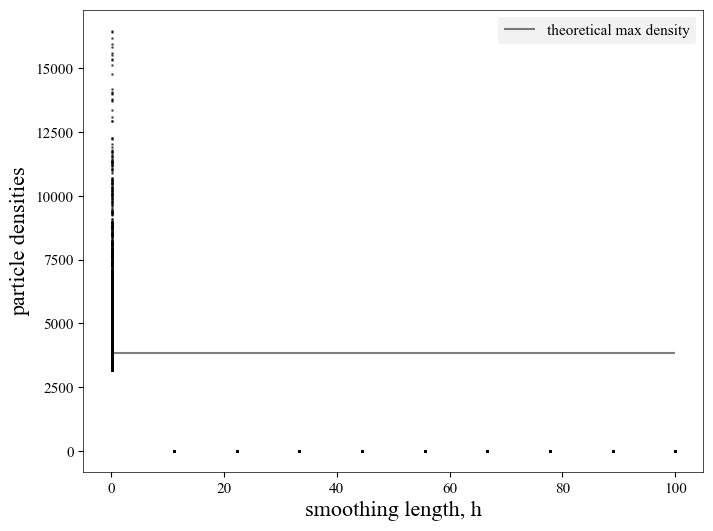

In [7]:
hlist = np.linspace(0.1, 100, 10)
for h in hlist:
    rhos_i = densities(pos, masses, h=h)
    plt.scatter([h]*len(rhos_i), rhos_i, color='k', s=1, alpha=0.5)
plt.xlabel('smoothing length, h', fontsize=16)
plt.ylabel('particle densities', fontsize=16)
plt.hlines(theoretical_max_density, xmin=hlist[0], xmax=hlist[-1], color='k', linestyle='-', label='theoretical max density', alpha=0.5, )
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()


# Density Gradient